In [1]:
import pandas as pd
import random
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from urllib.request import urlopen
import seaborn as sns
from scipy.stats import norm
import scipy.optimize as sco
import datetime

In [2]:
def get_close(tickers,
              start=datetime.date(datetime.date.today().year - 1, 
                datetime.date.today().month, 
                datetime.date.today().day)
                ,end=datetime.date.today()):
    
    data=pd.DataFrame()
    for ticker in tickers:

        try:

            yahoo_data=yf.Ticker(ticker)
            stock_price=yahoo_data.history(start=start,end=end,interval='1d').reset_index()
            stock_price['Date']=stock_price['Date'].dt.tz_localize(None)
            stock_price=stock_price.set_index('Date')
            stock_price[ticker]=stock_price['Close']+stock_price['Dividends'].shift(periods=-1)
            data=pd.concat([data,stock_price[ticker]],axis=1)

        except Exception as e:
            pass
        
    return data

In [3]:
stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]

In [4]:
tickers=stocks['Ticker'].to_list()

In [5]:
data=get_close(tickers,"2023-01-01")
data=data.dropna()
n=len(data.columns)

FLTR.IR: No data found, symbol may be delisted


In [6]:
returns=np.log(1+data.pct_change())

# Portfolio Construction

In [7]:
def halton_sequences(number,base=2):
    
    inv_base=1/base
    
    i=number
    halton=0
    
    while i>0:
        
        digit = i%base
        halton=halton + digit*inv_base
        i=(i-digit)/base
        inv_base=inv_base/base
        
    return halton

def generate_halton(iterations,dimensions=1,base=2):
    
    rng = np.random.default_rng()
    matrix=[]
    haltons=[]
    
    for i in range(iterations):
        halton=halton_sequences(i,base=base)
        haltons.append(halton)
    
    for dim in range(dimensions):
        
        matrix.append(haltons)
    
    matrix = rng.permuted(matrix, axis=1)
    return matrix

def near_psd(x, epsilon=0):

    if min(np.linalg.eigvals(x)) > epsilon:
        return x

    n = x.shape[0]
    var_list = np.array(np.sqrt(np.diag(x)))
    y = np.array([[x[i, j]/(var_list[i]*var_list[j]) for i in xrange(n)] for j in xrange(n)])

    eigval, eigvec = np.linalg.eig(y)
    val = np.matrix(np.maximum(eigval, epsilon))
    vec = np.matrix(eigvec)
    T = 1/(np.multiply(vec, vec) * val.T)
    T = np.matrix(np.sqrt(np.diag(np.array(T).reshape((n)) )))
    B = T * vec * np.diag(np.array(np.sqrt(val)).reshape((n)))
    near_corr = B*B.T    

    near_cov = np.array([[near_corr[i, j]*(var_list[i]*var_list[j]) for i in xrange(n)] for j in xrange(n)])
    return near_cov

def performance(perf,weights):
    
    return np.dot(perf,weights)


In [55]:
class Portfolio:
    
    def __init__(self,data,start_date=min(data.index),end_date=max(data.index)):
        
        self.data=data.loc[start_date:end_date]

    def portfolio(self,weights):
            
        portfolio=pd.DataFrame()
        portfolio['Portfolio']=np.sum(weights*returns,axis=1)
        
        return portfolio
    
    def evolution(self,weights):
        
        portfolio=self.portfolio(weights)
        evolution=(1+portfolio).cumprod()*100
        
        return evolution
    
    def performance(self,weights):
        performance=np.sum(self.data*weights).mean()*252
        return performance
    
    def variance(self,weights):
        variance=np.sqrt(np.dot(weights.T,np.dot(self.data.cov(),weights)))*np.sqrt(252)
        return variance
    
    def sharpe_ratio(weights):
            return self.performance(weights)/self.variance(weights)

    def optimize(self,objective='minimum_variance',constraints=False):
        
            
        def sum_equal_one(weight):
            return np.sum(weight) - 1   
        
        def sharpe_ratio(weights):
            return - self.performance(weights)/self.variance(weights)
        
        def variance(weights):
            variance=np.sqrt(np.dot(weights.T,np.dot(self.data.cov(),weights)))*np.sqrt(252)
            return variance
        
        n_assets = len(self.data.columns)
        weight = np.array([1 / n_assets] * n_assets)
        bounds = tuple((0, 1) for _ in range(n_assets))
        
        if not constraints:
            
            constraints = [{'type': 'eq', 'fun': sum_equal_one}]
        
        else:
            
            constraints=[{'type': 'eq', 'fun': sum_equal_one}]+constraints
        
        if objective=='minimum_variance':

            optimum_weights = sco.minimize(variance, weight, method='SLSQP', bounds=bounds, constraints=constraints)
        
        elif objective=='sharpe_ratio':
            
            optimum_weights = sco.minimize(sharpe_ratio, weight, method='SLSQP', bounds=bounds, constraints=constraints)
            
        else:
            
            print("Objective function undefined")
            
            
        return optimum_weights.x
    
    def black_Litterman(self,P,Q,weights,risk_aversion,tau=0.025):
        
        implied_returns=risk_aversion*self.data.cov().dot(weights).squeeze()
        omega=np.diag(np.diag(P.dot(tau*self.data.cov()).dot(P.T)))
        sigma_scaled=self.data.cov()*tau
        BL_returns= implied_returns + sigma_scaled.dot(P.T).dot(np.linalg.inv(P.dot(sigma_scaled).dot(P.T))+omega).dot(Q-P.dot(implied_returns))
        inv_cov=np.linalg.inv(self.data.cov())
        BL_weights=inv_cov.dot(BL_returns)
        BL_weights=BL_weights/BL_weights.sum()
        
        return BL_weights,BL_returns

## Risk Analysis

In [934]:
class RiskAnalysis(Portfolio):
    
    def __init__(self,returns,start_date=min(returns.index),end_date=max(returns.index)):
        
        self.returns=returns.loc[start_date:end_date]
        super().__init__(data=self.returns)
        

    def historical_var(self,weights,last_days=False,Q=5):

        performance=super().portfolio(weights)
        
        if last_days:
            performance=performance[-last_days:]
            
        var=np.percentile(performance,Q)
        cvar=performance[performance<var].mean().values[0]
        
        return var,cvar
    
    
    def parametric_var(self,weights,Q=0.95):
        
        intervals=np.arange(Q, 1, 0.0005, dtype=float)
        
        variance=super().variance(weights)
        VaR=variance/np.sqrt(252)*norm(loc =0 , scale = 1).ppf(1-Q)
        CVaR=variance/np.sqrt(252)*norm(loc =0 , scale = 1).ppf(1-intervals).mean()
        
        return VaR,CVaR
        
        
    def multivariate_distribution(self,
                    stress_factor=1.0,
                    iterations=10000):
        
        num_asset=len(self.returns.columns)
        
        if type(stress_factor)==float:
            
            stress_vec=np.linspace(stress_factor,stress_factor,num_asset)
            
        else:       
            stress_vec=stress_factor
            
        stress_matrix=np.diag(stress_vec)
        stress_matrix=pd.DataFrame(stress_matrix,columns=self.returns.columns,index=self.returns.columns)
        
        stressed_cov=self.returns.cov().dot(stress_matrix)
        mean=self.returns.mean()
        
        multivariate=np.random.multivariate_normal(mean,stressed_cov,iterations)
        
        
        return multivariate
    
    
    def rolling_var(self,weights,window=30,Q=1):
        
        value_at_risk=pd.DataFrame()
        
        mean=returns.rolling(window).mean().dropna()
        cov=returns.rolling(window).cov().dropna()

        index=tuple(set(cov.index.get_level_values(0)))


        var={}

        for date in index:

            multivariate_var=performance(np.random.multivariate_normal(mean.loc[date],cov.loc[date],10000),weights)
            var[date]=np.percentile(multivariate_var,Q)

        multivariate_var=pd.DataFrame(var.values(),index=var.keys())
        
        portfolio=super().portfolio(weights)
        
        value_at_risk['Historical']=portfolio.rolling(window=window).apply(lambda x:np.percentile(x,Q))
        value_at_risk['Parametric']=portfolio.rolling(window=window).std()*norm(loc =0 , scale = 1).ppf(Q/100)
        value_at_risk['Multivariate']=multivariate_var
        value_at_risk['Portfolio']=portfolio
        
        return value_at_risk

    def pca(self,num_components=2):
        
        cov_matrix=self.returns.cov()
        
        cov_matrix=returns.cov()
        
        eig_val, eig_vec=np.linalg.eig(cov_matrix)
        
        sorted_eig_val=eig_val.argsort()[::-1]
        
        eig_val=eig_val[sorted_eig_val]
        eig_vec=eig_vec[:,sorted_eig_val]
        
        eig_val=eig_val[:num_components]
        
        eig_vec=eig_vec[:,0:num_components]
        
        
        return eig_val,eig_vec
                
    
    def monte_carlo(self,spot,horizon=20/250,iterations=100000,stress_factor=1.0):
        
        
        
        num_asset=len(self.returns.columns)
        #haltons=generate_halton(iterations,num_asset,base=2)
        randoms=np.random.normal(size=(10000,num_asset)).T
        
        #cree une matrice de stress pour envoyer des shock sur les corrélations
        if type(stress_factor)==float:
            
            stress_vec=np.linspace(stress_factor,stress_factor,num_asset)
            
        else: 
            
            stress_vec=stress_factor
        
        # Multiplication des volatilités par un facteur de stress
        
        vol=self.returns.std()*np.sqrt(250)*stress_vec
        
        # Cree une matrice diagonale de facteurs de stress pour perturber la matrice de covariance
        
        stress_matrix=np.diag(stress_vec)
        stress_matrix=pd.DataFrame(stress_matrix,columns=self.returns.columns,index=self.returns.columns)
        
        
        # trouve la matrice de covariance semie definie positive 
        # la plus proche apres avoir appliquée les choque a la matrice de covariance
        
        stressed_cov=self.returns.cov().dot(stress_matrix)
        stressed_std=np.sqrt(np.diag(stressed_cov))
        corr_matrix=stressed_cov/np.outer(stressed_std,stressed_std)
        sdp_corr_matrix=near_psd(corr_matrix)
        
        #calcule la decomposition de Cholesky 
        cholesky=np.linalg.cholesky(corr_matrix)
            
        drift=np.exp(-0.5*horizon*vol**2)
        factors=spot*drift
        factors_vec=factors.to_numpy().reshape(num_asset,-1)
                
        simulation=np.matmul(cholesky,randoms).T
        simulation=pd.DataFrame(simulation)
        simulation.columns=self.returns.columns
 
        
        monte_carlo=factors_vec.T*np.exp(simulation.dot(np.diag(vol))*np.sqrt(horizon))
        monte_carlo=pd.DataFrame(monte_carlo)
        monte_carlo.columns=self.returns.columns
        perf_monte_carlo=np.log(monte_carlo/spot)
        
        return monte_carlo,perf_monte_carlo
    
    
    

In [935]:
test=RiskAnalysis(returns)

In [936]:
num_asset=len(data.columns)
weights=np.random.rand(num_asset)
weights=weights/weights.sum()

In [957]:
weights=test.optimize(objective="minimum_variance",constraints=[{'type': 'ineq', 'fun': lambda weights: 0.1 - weights}])
weights=np.round(weights,2)

In [958]:
var,cvar=test.historical_var(weights)
var,cvar

(-0.00927455778466347, -0.012250355919538844)

In [959]:
var,cvar=test.parametric_var(weights)
var,cvar

(-0.009389295508977814, -0.012034480846076083)

In [960]:
perf=performance(test.multivariate_distribution(),weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.008978059463034812, -0.011571964811050555)

In [961]:
spot=data.iloc[-1]
monte_carlo=test.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1],weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.00957077747281661, -0.011894231596973812)

In [968]:
stuf=test.rolling_var(weights,window=30,Q=1).dropna()

In [969]:
stuf['Overshoot']=np.where(stuf['Portfolio']<stuf['Historical'],1,0)

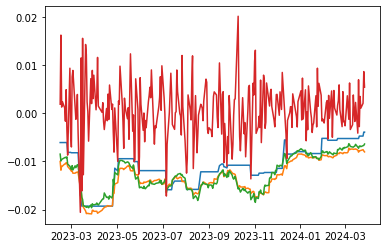

In [970]:
plt.plot(stuf[['Historical','Parametric','Multivariate','Portfolio']])

In [973]:
stuf.iloc[np.where(stuf['Overshoot']==1)]

,Historical,Parametric,Multivariate,Portfolio,Overshoot
2023-02-24,-0.008109,-0.011043,-0.010522,-0.008674,1
2023-03-13,-0.017126,-0.015473,-0.014800,-0.020578,1
2023-05-24,-0.010023,-0.011730,-0.011878,-0.010041,1
2023-05-30,-0.011899,-0.013749,-0.014403,-0.012658,1
2023-07-06,-0.015874,-0.015556,-0.016471,-0.017187,1
2023-10-27,-0.012858,-0.016654,-0.017950,-0.013619,1
2023-12-14,-0.008456,-0.011492,-0.010379,-0.009431,1


In [846]:
eigval,eigvec=test.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.555422  , 0.21576647, 0.10276708, 0.06874698, 0.05729747])

In [542]:
X_reduced=np.dot(eigvec.transpose(),returns.transpose()).transpose()

t=pd.DataFrame(X_reduced)

pc1 = eigvec[:,0]
pc1=pc1/pc1.sum()


In [ ]:
test.evolution(pc1).plot()

((1+get_close(['^STOXX50E']).pct_change()).cumprod()*100).plot()